# Анализ городов Казахстана
Сбор данных о городах и анализ качества воздуха


In [10]:
# Install required packages (run this cell first if packages are not installed)
%pip install requests pandas cloudscraper beautifulsoup4 matplotlib seaborn

import re
import requests
import pandas as pd
import cloudscraper
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://latitude.to/map/kz/kazakhstan/cities/by-population/page/1"



[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1. Загрузка данных о городах


In [11]:
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

cities_data = []

cities_listing = soup.find('div', class_='b-cities-listing')
city_items = cities_listing.find_all('li')

for item in city_items:
    city_link = item.find('a')
    city_name = city_link.text.strip()
    
    population_em = item.find('em')
    population_text = population_em.text.strip()
    population_str = re.sub(r'[(),\s]', '', population_text)
    population = int(population_str)
    
    if population > 100000:
        print(f"{city_name}: {population:,}")
        
        city_url = f"https://latitude.to/map/kz/kazakhstan/cities/{city_name.lower().replace(' ', '-')}"
        response = requests.get(city_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        coord_div = soup.find('div', class_='coord DD')
        
        if coord_div:
            coord_input = coord_div.find('input', {'name': 'DD'})
            if coord_input:
                coord_value = coord_input.get('value')
                lat, lng = coord_value.split()
                print(f" Latitude: {lat}, Longitude: {lng}")
            else:
                lat = None
                lng = None
        else:
            lat = None
            lng = None
        
        cities_data.append({
            'city': city_name,
            'population': population,
            'lat': lat,
            'lng': lng
        })

Almaty: 2,000,900
 Latitude: 43.25654, Longitude: 76.92848
Karagandy: 451,800
 Latitude: 49.83333, Longitude: 73.1658
Shymkent: 414,032
 Latitude: 42.3, Longitude: 69.6
Taraz: 358,153
 Latitude: 42.9, Longitude: 71.36667
Astana: 345,604
 Latitude: 51.1801, Longitude: 71.44598
Pavlodar: 329,002
 Latitude: 52.28333, Longitude: 76.96667
Ust-Kamenogorsk: 319,067
 Latitude: 49.97143, Longitude: 82.60586
Kyzylorda: 300,000
 Latitude: 44.85278, Longitude: 65.50917
Kyzyl-Orda: 300,000
 Latitude: 44.8479, Longitude: 65.49989
Semey: 292,780
 Latitude: 50.42675, Longitude: 80.26669
Aqtöbe: 262,457
Kostanay: 210,000
 Latitude: 53.21435, Longitude: 63.62463
Petropavl: 200,920
 Latitude: 54.86667, Longitude: 69.15
Oral: 200,000
 Latitude: 51.23333, Longitude: 51.36667
Taldyqorghan: 200,000
 Latitude: 45.0, Longitude: 77.91667
Atyrau: 180,000
 Latitude: 47.11667, Longitude: 51.88333
Temirtau: 170,600
 Latitude: 50.05494, Longitude: 72.96464
Aktau: 147,443
 Latitude: 43.65, Longitude: 51.16667
Kokshet

In [12]:
df = pd.DataFrame(cities_data)
df = df.sort_values('population', ascending=False)

print("\nDataFrame:")
print(df)


DataFrame:
               city  population       lat       lng
0            Almaty     2000900  43.25654  76.92848
1         Karagandy      451800  49.83333   73.1658
2          Shymkent      414032      42.3      69.6
3             Taraz      358153      42.9  71.36667
4            Astana      345604   51.1801  71.44598
5          Pavlodar      329002  52.28333  76.96667
6   Ust-Kamenogorsk      319067  49.97143  82.60586
7         Kyzylorda      300000  44.85278  65.50917
8        Kyzyl-Orda      300000   44.8479  65.49989
9             Semey      292780  50.42675  80.26669
10           Aqtöbe      262457      None      None
11         Kostanay      210000  53.21435  63.62463
12        Petropavl      200920  54.86667     69.15
13             Oral      200000  51.23333  51.36667
14     Taldyqorghan      200000      45.0  77.91667
15           Atyrau      180000  47.11667  51.88333
16         Temirtau      170600  50.05494  72.96464
17            Aktau      147443     43.65  51.16667


## 2. Фильтрация административных центров


In [16]:
total_population = df['population'].sum()
avg_population = df['population'].mean()
max_population = df['population'].max()
min_population = df['population'].min()

print(f"Общее население: {total_population}")
print(f"Среднее население: {avg_population}")
print(f"Максимум: {max_population}")
print(f"Минимум: {min_population}")
print(f"Стандартное отклонение: {df['population'].std()}")
print(f"Медиана: {df['population'].median()}")

Общее население: 7377185
Среднее население: 307382.7083333333
Максимум: 2000900
Минимум: 103598
Стандартное отклонение: 374887.32341499504
Медиана: 205460.0


## 3. Базовая статистика


In [ ]:
print("\nТоп-3 самых крупных города:")
top3 = df.nlargest(3, 'population')[['city', 'population']]
print(top3)



Топ-3 самых крупных города:
        city  population
0     Almaty     2000900
1  Karagandy      451800
2   Shymkent      414032


## 4. Получение данных о качестве воздуха


In [21]:
def get_air_quality(lat, lng):
    url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={lat}&longitude={lng}&hourly=pm10,pm2_5"
    response = requests.get(url)
    return response.json()


In [25]:
air_quality_results = []

for idx, row in df.iterrows():
    city = row['city']
    lat = row['lat']
    lng = row['lng']
    
    print(f"Получение данных для {city}")
    
    air_data = get_air_quality(lat, lng)
    
    if 'hourly' in air_data:
        pm10_values = [v for v in air_data['hourly']['pm10'] if v is not None]
        pm25_values = [v for v in air_data['hourly']['pm2_5'] if v is not None]
        
        air_quality_results.append({
            'city': city,
            'pm10_avg': sum(pm10_values) / len(pm10_values),
            'pm25_avg': sum(pm25_values) / len(pm25_values),
            'pm10_max': max(pm10_values),
            'pm25_max': max(pm25_values)
        })

df_air = pd.DataFrame(air_quality_results)
print(f"Получены данные для {len(df_air)} городов")

Получение данных для Almaty
Получение данных для Karagandy
Получение данных для Shymkent
Получение данных для Taraz
Получение данных для Astana
Получение данных для Pavlodar
Получение данных для Ust-Kamenogorsk
Получение данных для Kyzylorda
Получение данных для Kyzyl-Orda
Получение данных для Semey
Получение данных для Aqtöbe
Получение данных для Kostanay
Получение данных для Petropavl
Получение данных для Oral
Получение данных для Taldyqorghan
Получение данных для Atyrau
Получение данных для Temirtau
Получение данных для Aktau
Получение данных для Kokshetau
Получение данных для Rudnyy
Получение данных для Ekibastuz
Получение данных для Taldykorgan
Получение данных для Zhezqazghan
Получение данных для Zhanaozen
Получены данные для 23 городов


## 5. Объединение данных


In [26]:
df_final = df.merge(df_air, on='city', how='left')
df_final[['city', 'population', 'pm10_avg', 'pm25_avg']]


,city,population,pm10_avg,pm25_avg
0,Almaty,2000900,28.441284,24.772477
1,Karagandy,451800,13.981651,12.327523
2,Shymkent,414032,22.477064,19.508257
3,Taraz,358153,18.388073,14.222018
4,Astana,345604,13.364220,12.470642
5,Pavlodar,329002,12.117431,11.432110
6,Ust-Kamenogorsk,319067,15.256881,12.233028
7,Kyzylorda,300000,11.211009,9.440367
8,Kyzyl-Orda,300000,11.211009,9.440367
9,Semey,292780,10.825688,9.965138


## 6. Анализ качества воздуха


In [ ]:
print("ТОП-5 ГОРОДОВ С ХУДШИМ КАЧЕСТВОМ ВОЗДУХА (PM2.5)")
df_final.nlargest(5, 'pm25_avg')[['city', 'pm25_avg', 'population']]


=== ТОП-5 ГОРОДОВ С ХУДШИМ КАЧЕСТВОМ ВОЗДУХА (PM2.5) ===


,city,pm25_avg,population
0,Almaty,24.772477,2000900
2,Shymkent,19.508257,414032
23,Zhanaozen,16.305505,103598
16,Temirtau,16.026606,170600
17,Aktau,15.281651,147443


In [ ]:
print("ТОП-5 ГОРОДОВ С ЛУЧШИМ КАЧЕСТВОМ ВОЗДУХА (PM2.5)")
df_final.nsmallest(5, 'pm25_avg')[['city', 'pm25_avg', 'population']]


=== ТОП-5 ГОРОДОВ С ЛУЧШИМ КАЧЕСТВОМ ВОЗДУХА (PM2.5) ===


,city,pm25_avg,population
18,Kokshetau,5.665138,124444
19,Rudnyy,6.626606,124000
12,Petropavl,6.734862,200920
13,Oral,7.680734,200000
20,Ekibastuz,7.717431,121470


In [30]:
print("СТАТИСТИКА КАЧЕСТВА ВОЗДУХА")
print("PM10:")
print(f"Среднее: {df_final['pm10_avg'].mean()}")
print(f"Максимум: {df_final['pm10_avg'].max()}")
print(f"Минимум: {df_final['pm10_avg'].min()}")
print("PM2.5:")
print(f"Среднее: {df_final['pm25_avg'].mean()}")
print(f"Максимум: {df_final['pm25_avg'].max()}")
print(f"Минимум: {df_final['pm25_avg'].min()}")

СТАТИСТИКА КАЧЕСТВА ВОЗДУХА
PM10:
Среднее: 18.359154367770245
Максимум: 83.87339449541281
Минимум: 6.148623853211007
PM2.5:
Среднее: 11.765935380933387
Максимум: 24.772477064220187
Минимум: 5.665137614678899


## 7. Data Cleaning & Preparation


In [31]:
print("Пропущенные значения:")
print(df_final.isnull().sum())

df_final['pm10_avg'] = df_final['pm10_avg'].fillna(df_final['pm10_avg'].median())
df_final['pm25_avg'] = df_final['pm25_avg'].fillna(df_final['pm25_avg'].median())
df_final['pm10_max'] = df_final['pm10_max'].fillna(df_final['pm10_max'].median())
df_final['pm25_max'] = df_final['pm25_max'].fillna(df_final['pm25_max'].median())

print("Дубликаты:")
duplicates = df_final.duplicated(subset=['city'])
print(duplicates.sum())

df_final = df_final.rename(columns={
    'lat': 'latitude',
    'lng': 'longitude',
    'admin_name': 'region',
    'pm10_avg': 'pm10_average',
    'pm25_avg': 'pm25_average',
    'pm10_max': 'pm10_maximum',
    'pm25_max': 'pm25_maximum'
})

print("Типы данных:")
print(df_final.dtypes)

def categorize_air_quality(pm25_value):
    if pm25_value <= 10:
        return "Good"
    elif pm25_value <= 25:
        return "Moderate"
    elif pm25_value <= 50:
        return "Unhealthy for Sensitive Groups"
    else:
        return "Unhealthy"

df_final['air_quality_category'] = df_final['pm25_average'].apply(categorize_air_quality)

def categorize_population(pop_value):
    if pop_value >= 1000000:
        return "Large City (1M+)"
    elif pop_value >= 500000:
        return "Medium City (500K-1M)"
    elif pop_value >= 200000:
        return "Small City (200K-500K)"
    else:
        return "Very Small City (<200K)"

df_final['city_size_category'] = df_final['population'].apply(categorize_population)

print(f"Форма датасета: {df_final.shape}")
print(f"Колонки: {list(df_final.columns)}")

Пропущенные значения:
city          0
population    0
lat           1
lng           1
pm10_avg      1
pm25_avg      1
pm10_max      1
pm25_max      1
dtype: int64
Дубликаты:
0
Типы данных:
city             object
population        int64
latitude         object
longitude        object
pm10_average    float64
pm25_average    float64
pm10_maximum    float64
pm25_maximum    float64
dtype: object
Форма датасета: (24, 10)
Колонки: ['city', 'population', 'latitude', 'longitude', 'pm10_average', 'pm25_average', 'pm10_maximum', 'pm25_maximum', 'air_quality_category', 'city_size_category']


## 9. Exploratory Data Analysis (EDA)


In [33]:
print("Статистика:")
print(df_final[['population', 'pm10_average', 'pm25_average']].describe())

print("Корреляция:")
correlation_matrix = df_final[['population', 'pm10_average', 'pm25_average']].corr()
print(f"Population vs PM10: {correlation_matrix.loc['population', 'pm10_average']}")
print(f"Population vs PM2.5: {correlation_matrix.loc['population', 'pm25_average']}")
print(f"PM10 vs PM2.5: {correlation_matrix.loc['pm10_average', 'pm25_average']}")

print("Распределение населения:")
print(f"Mean: {df_final['population'].mean()}")
print(f"Median: {df_final['population'].median()}")
print(f"Std Dev: {df_final['population'].std()}")

print("Распределение PM2.5:")
print(f"Mean: {df_final['pm25_average'].mean()}")
print(f"Median: {df_final['pm25_average'].median()}")
print(f"Std Dev: {df_final['pm25_average'].std()}")

print("Категории качества воздуха:")
air_quality_dist = df_final['air_quality_category'].value_counts()
print(air_quality_dist)

print("Размер города vs качество воздуха:")
size_air_quality = df_final.groupby('city_size_category')['pm25_average'].agg(['mean', 'median', 'count'])
print(size_air_quality)

print("Регионы с худшим воздухом:")

print("Выбросы:")
Q1 = df_final['pm25_average'].quantile(0.25)
Q3 = df_final['pm25_average'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_final[(df_final['pm25_average'] < lower_bound) | (df_final['pm25_average'] > upper_bound)]
print(f"PM2.5 выбросов: {len(outliers)} городов")
print(outliers[['city', 'pm25_average', 'population']].sort_values('pm25_average', ascending=False))

Статистика:
         population  pm10_average  pm25_average
count  2.400000e+01     24.000000     24.000000
mean   3.073827e+05     18.151032     11.752026
std    3.748873e+05     16.964897      4.405210
min    1.035980e+05      6.148624      5.665138
25%    1.416932e+05     10.396789      9.016972
50%    2.054600e+05     13.364220     11.432110
75%    3.215508e+05     17.959404     13.236697
max    2.000900e+06     83.873394     24.772477
Корреляция:
Population vs PM10: 0.06461816454945428
Population vs PM2.5: 0.6825218917468822
PM10 vs PM2.5: 0.5478792707653286
Распределение населения:
Mean: 307382.7083333333
Median: 205460.0
Std Dev: 374887.32341499504
Распределение PM2.5:
Mean: 11.752025993883793
Median: 11.432110091743121
Std Dev: 4.405209954344323
Категории качества воздуха:
air_quality_category
Moderate    15
Good         9
Name: count, dtype: int64
Размер города vs качество воздуха:
                              mean     median  count
city_size_category                         

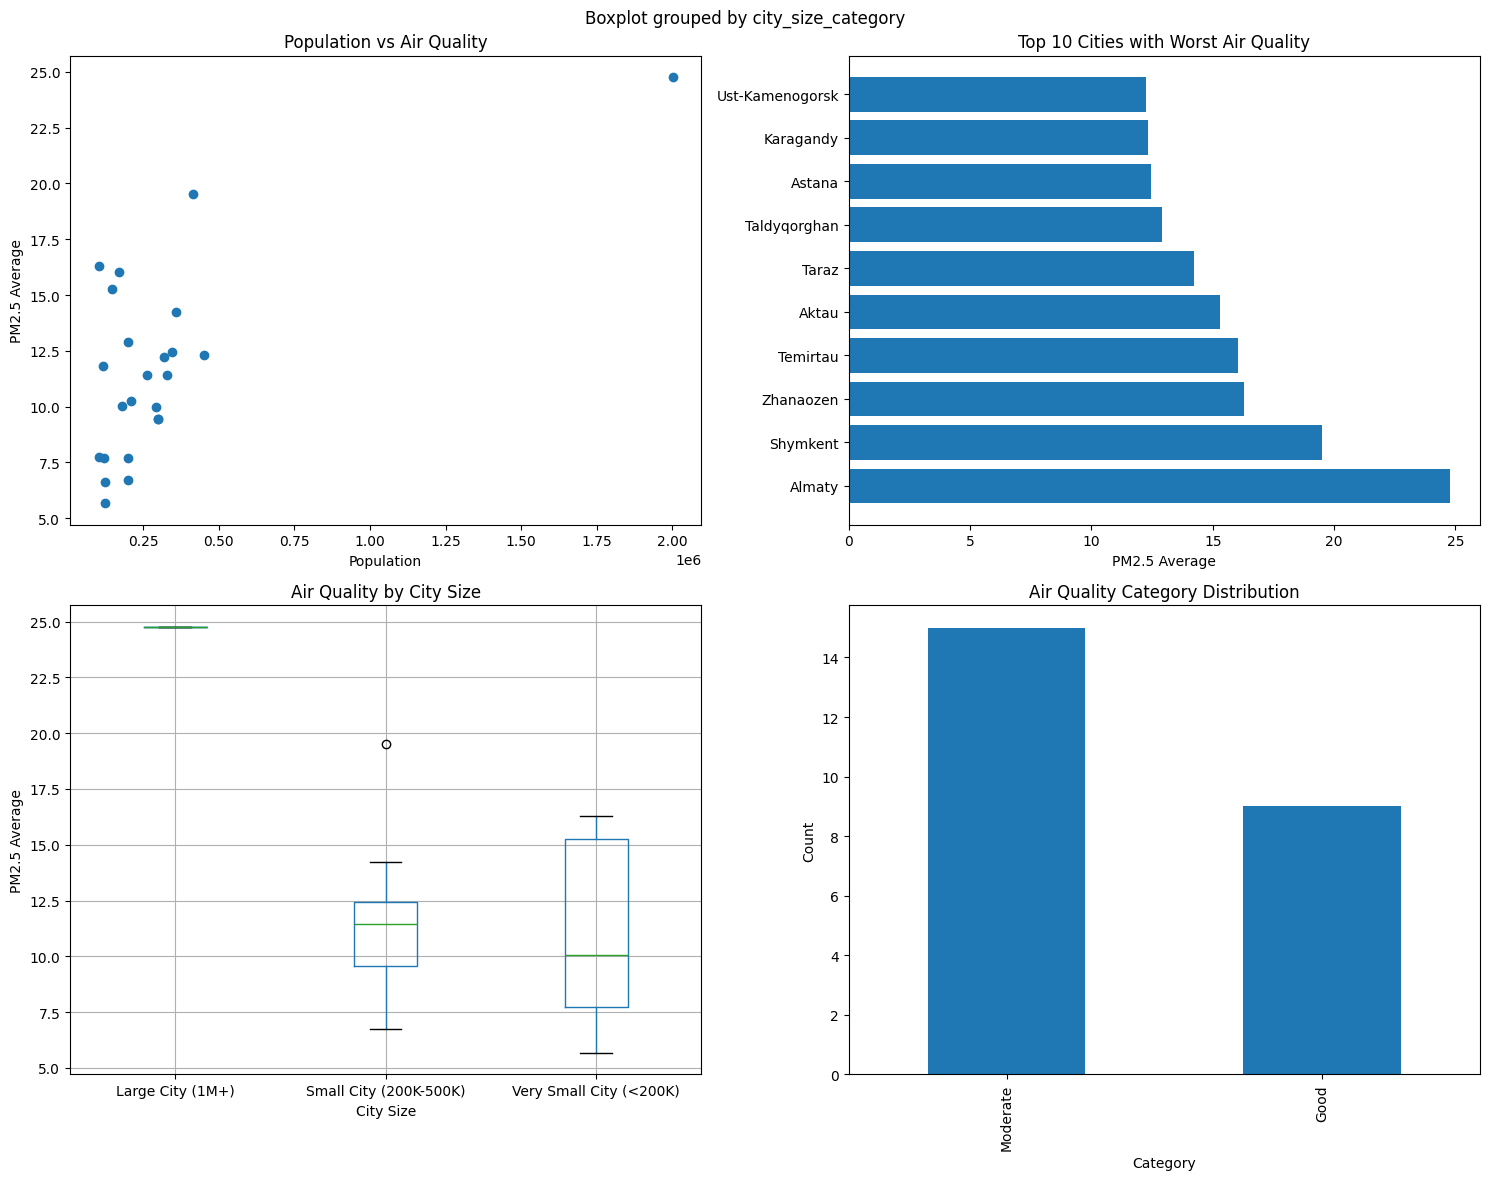

Собрано данных: 24 городов
Пропущенных значений: 2
Худший воздух: Almaty (24.772477064220187)
Лучший воздух: Kokshetau (5.665137614678899)
Корреляция население-воздух: 0.6825218917468822
Распределение качества воздуха:
air_quality_category
Moderate    15
Good         9
Name: count, dtype: int64


In [36]:
def create_visualizations(df_final):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    ax1 = axes[0, 0]
    ax1.scatter(df_final['population'], df_final['pm25_average'])
    ax1.set_xlabel('Population')
    ax1.set_ylabel('PM2.5 Average')
    ax1.set_title('Population vs Air Quality')
    
    ax2 = axes[0, 1]
    top_cities = df_final.nlargest(10, 'pm25_average')
    ax2.barh(range(len(top_cities)), top_cities['pm25_average'])
    ax2.set_yticks(range(len(top_cities)))
    ax2.set_yticklabels(top_cities['city'])
    ax2.set_xlabel('PM2.5 Average')
    ax2.set_title('Top 10 Cities with Worst Air Quality')
    
    ax3 = axes[1, 0]
    df_final.boxplot(column='pm25_average', by='city_size_category', ax=ax3)
    ax3.set_title('Air Quality by City Size')
    ax3.set_xlabel('City Size')
    ax3.set_ylabel('PM2.5 Average')
    
    ax4 = axes[1, 1]
    df_final['air_quality_category'].value_counts().plot(kind='bar', ax=ax4)
    ax4.set_title('Air Quality Category Distribution')
    ax4.set_xlabel('Category')
    ax4.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

def generate_summary_insights(df_final):
    print(f"Собрано данных: {len(df_final)} городов")
    print(f"Пропущенных значений: {df_final.isnull().sum().sum()}")
    
    worst_air = df_final.loc[df_final['pm25_average'].idxmax()]
    best_air = df_final.loc[df_final['pm25_average'].idxmin()]
    print(f"Худший воздух: {worst_air['city']} ({worst_air['pm25_average']})")
    print(f"Лучший воздух: {best_air['city']} ({best_air['pm25_average']})")
    
    correlation = df_final['population'].corr(df_final['pm25_average'])
    print(f"Корреляция население-воздух: {correlation}")
    
    air_quality_summary = df_final['air_quality_category'].value_counts()
    print("Распределение качества воздуха:")
    print(air_quality_summary)

create_visualizations(df_final)
generate_summary_insights(df_final)